# Proyecto Final — Aprendizaje Automatizado  
### Semestre 2025-2  
**Elizabeth Ríos Alvarado**  
**Daniel Rojo Mata**


# Predicción de Días con Alta Volatilidad en el Mercado Bursátil

## Objetivo del Proyecto

El objetivo de este trabajo es desarrollar un sistema de clasificación capaz de **predecir días con alta volatilidad en el mercado accionario**, utilizando datos financieros históricos y técnicas de aprendizaje automático. Se busca detectar estos eventos de manera anticipada, lo cual es clave para estrategias de inversión y gestión de riesgo.

---

## Enfoque General

El proyecto se divide en varias etapas clave:

### 1. **Descarga y preparación de datos**
- Se utilizaron precios históricos de acciones descargados desde *Yahoo Finance* mediante `FinRL`.
- Se calcularon los **rendimientos diarios** y una medida de **volatilidad de 5 días** usando desviación estándar.
- Los datos fueron enriquecidos con múltiples **indicadores técnicos** (ej. RSI, MACD, Bollinger Bands).

### 2. **Etiquetado de alta volatilidad**
- Se definió un umbral dinámico de alta volatilidad utilizando el **percentil 70** de la volatilidad histórica por acción.
- Se creó una variable binaria `volatilidad_alta` que indica si un día tiene una volatilidad anormalmente alta para esa acción.

### 3. **Estudio empírico de atributos**
- Se realizó un **estudio empírico para evaluar la importancia de distintas combinaciones de columnas**.
- Se utilizó una **estrategia evolutiva basada en algoritmos genéticos** para seleccionar subconjuntos de atributos y evaluar su rendimiento.
- El resultado concluyó que **utilizar toda la información disponible produce mejores resultados** que cualquier subconjunto reducido.

### 4. **Modelado clásico**
- Se probaron distintos modelos de clasificación supervisada:
  - Regresión Logística
  - Random Forest
  - XGBoost
  - SVM
  - K-Nearest Neighbors
- Se evaluó el rendimiento con la métrica **F1-score**, dada la naturaleza desbalanceada del problema.

### 5. **Modelado secuencial con RNN**
- Se entrenó una **Red Neuronal Recurrente (LSTM)** que usa secuencias temporales de 15 días para predecir la volatilidad del día siguiente.
- Se compararon dos variantes:
  - RNN sin ajuste de pesos.
  - RNN con **pesos de clase** para mitigar el desbalance de etiquetas.
- Se realizó una **búsqueda automática del umbral de decisión** para maximizar el F1-score.

---

## Resultados clave

- Los modelos clásicos tuvieron un rendimiento limitado, especialmente en términos de recall para la clase positiva.
- El mejor rendimiento fue obtenido con la **RNN con pesos de clase**, que logró un **recall del 100%** y un **F1-score de 0.4586** para detectar días de alta volatilidad.
- La búsqueda del umbral óptimo reveló que valores bajos (ej. **0.05**) permiten captar más eventos relevantes.
- El estudio evolutivo de selección de columnas permitió confirmar que **la inclusión de todas las variables mejora consistentemente el desempeño predictivo**.

---

## Conclusión

El enfoque secuencial con RNN, ajustado por pesos y con umbral calibrado, representa una solución efectiva para la predicción de días con alta volatilidad. Este tipo de modelos puede ser especialmente útil para sistemas de alerta temprana en trading algorítmico o gestión de riesgo. El análisis evolutivo también sugiere que reducir atributos puede ser contraproducente: **más información aporta mayor poder predictivo** en este contexto.

# **Ajustar Anchura** 

Esta línea hace que se ajuste la anchura del notebook, por defecto la ajusta a un 92%

In [1]:
# Permite ajustar la anchura de la parte útil de la libreta (reduce los márgenes)
from IPython.display import display, HTML
display(HTML("<style>.container{ width:92% }</style>"))

# **Descargar Dependencias**

Estos son los elementos que se tienen que descargar para un uso adecuado de todo el notebook. 

In [2]:
# !pip install swig
# !pip install wrds
# !pip install pyportfolioopt
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
# !pip install yfinance
# !pip install pandas_market_calendars

# **Se importan las librerías**

In [3]:
# Manipulación de datos
import pandas as pd
import numpy as np
import random
import itertools

# Fechas y descarga de datos
import datetime
import yfinance as yf
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.config import INDICATORS

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modelado clásico
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score,
    precision_score,
    recall_score
)

# Deep learning (Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-06-01 14:55:00.399846: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 14:55:00.421949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-01 14:55:00.449666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-01 14:55:00.458246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-01 14:55:00.482374: I tensorflow/core/platform/cpu_feature_guar

# **Se descargan los datos históricos**

In [4]:
# IMPORTANTE: Las fechas deben seguir el formato 'año/mes/día' (YYYY-MM-DD)
# Estas fechas delimitan el periodo de tiempo del que se descargarán los datos históricos
START_DATE = '2024-01-01'   # Fecha de inicio del análisis
END_DATE = '2025-03-04'     # Fecha de fin del análisis

# Lista de símbolos (tickers) de las acciones que se analizarán
# Estos corresponden a empresas cotizadas en bolsa como Moderna, Nvidia, Uber, etc.
symbols = [
    "MRNA",  # Moderna Inc.
    "NVDA",  # Nvidia Corp.
    "UBER",  # Uber Technologies Inc.
    "ASML",  # ASML Holding N.V.
    "AMZN",  # Amazon.com Inc.
    "AAPL"   # Apple Inc.
]

# Usamos el módulo YahooDownloader de FinRL para descargar datos históricos de acciones
# Se especifica el rango de fechas y la lista de símbolos (acciones) definidos previamente
data = YahooDownloader(
    start_date = START_DATE,   # Fecha de inicio del periodo de análisis
    end_date = END_DATE,       # Fecha de fin del periodo de análisis
    ticker_list = symbols      # Lista de acciones a descargar (AAPL, AMZN, etc.)
).fetch_data()                 # Ejecuta la descarga y devuelve un DataFrame con los datos

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (1752, 8)


# **Extracción de Indicadores Técnicos y Reconstrucción de la Estructura Temporal**

### 1. Extracción de Indicadores Técnicos

Después de descargar los datos históricos de precios para varias acciones, se aplica un proceso de **ingeniería de características** para enriquecer el conjunto de datos con variables útiles para el modelo de aprendizaje automatizado.

Para esto, se utiliza el módulo `FeatureEngineer` de la biblioteca FinRL. Este módulo permite calcular automáticamente varios **indicadores técnicos**, que son ampliamente utilizados en el análisis técnico del mercado bursátil. Estos indicadores ayudan a capturar tendencias, momentum y señales de sobrecompra o sobreventa en los precios.

Entre los indicadores extraídos se encuentran:

- **RSI (Relative Strength Index)**
- **MACD (Moving Average Convergence Divergence)**
- **Bollinger Bands**
- **Medias móviles (SMA, EMA)**
- **CCI, DX, y más**

Además, se incluyen variables adicionales como:

- **VIX**: índice de volatilidad implícita del mercado, útil para medir el "miedo" del mercado.
- **Turbulence**: una medida del comportamiento anómalo del mercado basada en desviaciones multivariadas.

Estos indicadores se calculan para cada acción de forma individual y se agregan como nuevas columnas al DataFrame resultante (`processed`).

---

### 2. Reconstrucción de la estructura fecha × acción

Una vez que se tienen los indicadores técnicos, se realiza un paso adicional: **reconstruir la estructura completa del conjunto de datos**, garantizando que todas las combinaciones posibles de fechas y acciones estén presentes.

#### ¿Por qué se hace esto?

En el mundo real, no todas las acciones tienen datos disponibles para todas las fechas (por ejemplo, por días festivos, suspensiones de cotización o errores en la descarga). Para asegurar que el conjunto de datos sea consistente y estructurado (especialmente útil para modelos temporales), se realiza lo siguiente:

- Se genera una lista completa de fechas entre la mínima y máxima fecha observada.
- Se toma la lista de acciones (tickers) presentes en el conjunto de datos.
- Se calcula el **producto cartesiano** de fechas × acciones, creando todas las combinaciones posibles.
- Este nuevo DataFrame se fusiona con los datos procesados originales para **rellenar los valores existentes** y dejar explícitos los faltantes.
- Finalmente, se filtran las fechas que realmente ocurrieron en el mercado para evitar incluir días como fines de semana o festivos.

Este paso garantiza que el conjunto de datos tenga una estructura rectangular y ordenada, lo cual es especialmente útil para la fase de modelado.

---


In [5]:
# Creamos un objeto FeatureEngineer para calcular automáticamente indicadores técnicos
fe = FeatureEngineer(
    use_technical_indicator=True,        # Activamos el cálculo de indicadores técnicos clásicos (RSI, MACD, etc.)
    tech_indicator_list=INDICATORS,      # Usamos la lista predefinida de indicadores de FinRL
    use_vix=True,                        # Incluye el índice VIX (volatilidad implícita del mercado)
    use_turbulence=True,                 # Incluye la medida de turbulencia financiera
    user_defined_feature=False           # No se agregan indicadores personalizados por ahora
)

# Aplicamos el preprocesamiento sobre el DataFrame descargado ('data') para generar nuevas columnas con indicadores
processed = fe.preprocess_data(data)

# --- Reconstruimos la estructura completa fecha × acción para evitar combinaciones faltantes ---

# Obtenemos la lista única de tickers (acciones)
list_ticker = processed["tic"].unique().tolist()

# Creamos una lista de fechas entre la mínima y máxima fecha disponibles en el dataset
list_date = list(pd.date_range(processed['date'].min(), processed['date'].max()).astype(str))

# Generamos todas las combinaciones posibles de (fecha, ticker)
combination = list(itertools.product(list_date, list_ticker))

# Creamos un nuevo DataFrame con todas las combinaciones posibles (fecha, acción)
# Luego hacemos un left join con los datos procesados para rellenar los datos existentes
processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(
    processed, on=["date", "tic"], how="left"
)

# Filtramos para conservar solo las fechas que realmente estaban en los datos originales
# Esto evita que aparezcan fechas inexistentes (por ejemplo, fines de semana o días festivos)
processed_full = processed_full[processed_full['date'].isin(processed['date'])]

# Ordenamos los datos primero por 'tic' (símbolo de la acción) y luego por 'date'
# Esto es necesario para aplicar el rellenado hacia adelante (forward fill) correctamente dentro de cada acción
processed_full = processed_full.sort_values(['tic', 'date'])

# Rellenamos los valores faltantes con el último valor válido conocido hacia adelante (forward fill)
# Esto es útil porque algunos indicadores técnicos no tienen valor en los primeros días y así evitamos NaNs
processed_full = processed_full = processed_full.ffill()

# Eliminamos cualquier fila que aún tenga valores faltantes después del rellenado
# Esto suele ocurrir en los primeros días de cada acción, donde no hay valores previos para propagar
processed_full = processed_full.dropna()

#OPCIONAL: Visualizar la data
processed_full.head(5)

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (291, 8)
Successfully added vix
Successfully added turbulence index


,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2024-01-02,AAPL,184.290436,187.070083,182.553158,185.789453,82488700.0,1.0,0.000000,185.551971,181.648987,0.000000,-66.666667,100.000000,184.290436,184.290436,13.20,0.0
6,2024-01-03,AAPL,182.910522,184.528677,182.096477,182.880742,58414500.0,2.0,-0.030960,185.551971,181.648987,0.000000,-66.666667,100.000000,183.600479,183.600479,14.04,0.0
12,2024-01-04,AAPL,180.587540,181.758954,179.565029,180.825785,71983600.0,3.0,-0.111484,186.338879,178.853453,0.000000,-100.000000,100.000000,182.596166,182.596166,14.13,0.0
18,2024-01-05,AAPL,179.862839,181.431354,178.860187,180.666963,62303300.0,4.0,-0.171541,186.012795,177.812873,0.000000,-77.623069,100.000000,181.912834,181.912834,13.35,0.0
36,2024-01-08,AAPL,184.210999,184.250716,180.180517,180.766224,59144500.0,0.0,-0.027541,186.475211,178.269723,51.361033,26.022816,7.073623,182.372467,182.372467,13.08,0.0


# **Cálculo y Etiquetado de la Volatilidad**

## Parte 1: Cálculo de la Volatilidad de 5 Días

La volatilidad es una medida de qué tanto varían los precios de una acción en un periodo de tiempo. En este proyecto, la estimamos como la **desviación estándar de los rendimientos diarios** utilizando una **ventana móvil de 5 días** para cada acción por separado.

### ¿Qué se hace?

- Se agrupan los datos por acción (`tic`), porque cada empresa tiene su propia dinámica de precios.
- Se calcula el **rendimiento diario** como el cambio porcentual del precio de cierre.
- Sobre esos rendimientos, se aplica una **ventana móvil de 5 días** y se calcula la **desviación estándar**.
- Esta medida representa la **volatilidad reciente** de cada acción y se guarda en una columna nueva llamada `volatility_5d`.

### ¿Por qué usamos desviación estándar?

La desviación estándar cuantifica la **dispersión**: si los rendimientos varían mucho de un día a otro, su desviación estándar será alta. En finanzas, esta es una forma clásica y aceptada de medir la volatilidad, ya que refleja cuán impredecible ha sido el comportamiento de una acción en días recientes.

---

## Parte 2: Etiquetado de Días con "Alta Volatilidad"

Para poder entrenar modelos de clasificación, necesitamos transformar la variable continua `volatility_5d` en una etiqueta binaria. Lo hacemos creando una nueva columna `volatilidad_alta`, que indica si un día tiene **volatilidad inusualmente alta** o no.

### ¿Cómo se etiqueta?

- Nuevamente se agrupan los datos por acción (`tic`), ya que lo que se considera “alto” depende del contexto de cada empresa.
- Se calcula el **percentil 70** (también llamado percentil 0.70) de la volatilidad para cada acción.
- Este valor actúa como un **umbral relativo**: si un día tiene una volatilidad mayor a este umbral, se considera un evento anómalo o especialmente volátil.
- Se asigna:
  - `1` → si la volatilidad está por arriba del percentil 70
  - `0` → en caso contrario

### ¿Por qué usar el percentil 70?

El percentil 70 significa que **sólo el 30% de los días más volátiles** serán etiquetados como "alta volatilidad". Este valor nos da un **equilibrio natural** entre:
- Tener suficientes ejemplos positivos para entrenar modelos robustos.
- No etiquetar como “alto” cualquier pequeña variación común.

---

## Parte 3: Exploración de Percentiles

Antes de fijar el percentil 70, realizamos una pequeña exploración para entender qué proporción de días serían etiquetados como clase 1 (`volatilidad_alta`) con diferentes percentiles. Esto ayuda a asegurarnos de que no estamos seleccionando ni demasiados ni muy pocos días como "volátiles".

# Etiquetado

In [6]:
# 1. Ordenamos por acción y fecha
processed_full = processed_full.sort_values(['tic', 'date'])

# 2. Calculamos el rendimiento diario por acción
processed_full['return'] = processed_full.groupby('tic')['close'].pct_change()

# 3. Calculamos la volatilidad como desviación estándar de 5 días sobre los rendimientos
processed_full['volatility_5d'] = processed_full.groupby('tic')['return'].rolling(5).std().reset_index(0, drop=True)

# 4. Etiquetamos los días con volatilidad alta (top 30% por acción usando percentil 70)
def etiquetar_volatilidad(df, column='volatility_5d', percentil=0.70):
    umbrales = df.groupby('tic')[column].transform(lambda x: x.quantile(percentil))
    df['volatilidad_alta'] = (df[column] > umbrales).astype(int)
    return df

processed_full = etiquetar_volatilidad(processed_full, percentil=0.70)

# 5. Eliminamos filas con valores faltantes
processed_full = processed_full.dropna()

processed_full.head(5)

,date,tic,close,high,low,open,volume,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,return,volatility_5d,volatilidad_alta
42,2024-01-09,AAPL,183.794052,183.803974,181.401569,182.582920,42841800.0,1.0,0.041712,186.458200,...,48.871120,29.330820,7.073623,182.609398,182.609398,12.76,0.0,-0.002263,0.014335,0
48,2024-01-10,AAPL,184.836411,185.044875,182.582909,183.009791,46792900.0,2.0,0.132627,186.823495,...,54.567245,76.253282,13.207993,182.927543,182.927543,12.69,0.0,0.005671,0.013924,0
54,2024-01-11,AAPL,184.240768,185.690161,182.285089,185.183859,49128400.0,3.0,0.163126,186.816260,...,51.195632,66.899451,21.476001,183.091696,183.091696,12.44,0.0,-0.003223,0.011889,0
60,2024-01-12,AAPL,184.568359,185.382405,183.843671,184.707341,40444700.0,4.0,0.198018,186.876192,...,52.853039,85.516770,21.476001,183.255770,183.255770,12.70,0.0,0.001778,0.011165,0
84,2024-01-16,AAPL,182.295044,182.920454,179.614660,180.835729,65603000.0,1.0,0.102791,186.626723,...,42.493432,-66.784591,29.102518,183.159697,183.159697,13.84,0.0,-0.012317,0.006729,0


## Exploración de perceptiles


Se usa el perceptil 70 pues el que mejor balance nos da

In [7]:
for p in [0.60, 0.65, 0.70, 0.75]:
    df_temp = etiquetar_volatilidad(processed_full.copy(), percentil=p)
    clase_1 = df_temp['volatilidad_alta'].sum()
    total = len(df_temp)
    proporcion = clase_1 / total
    print(f"Percentil {p:.2f} → Clase 1: {clase_1} de {total} ({proporcion:.2%})")

Percentil 0.60 → Clase 1: 684 de 1716 (39.86%)
Percentil 0.65 → Clase 1: 600 de 1716 (34.97%)
Percentil 0.70 → Clase 1: 516 de 1716 (30.07%)
Percentil 0.75 → Clase 1: 432 de 1716 (25.17%)


# **Descripción de las columnas del DataFrame**

A continuación se describen brevemente las columnas del conjunto de datos:

- **close**: Precio de cierre de la acción en el día correspondiente.
- **high**: Precio más alto alcanzado por la acción durante el día.
- **low**: Precio más bajo alcanzado por la acción durante el día.
- **open**: Precio de apertura de la acción en ese día.
- **volume**: Volumen de operaciones (cantidad de acciones intercambiadas en el día).
- **day**: Día de la semana representado como número (0 = lunes, 6 = domingo).

### Indicadores técnicos (features extraídas automáticamente):
- **macd**: Media móvil de convergencia/divergencia, indicador de momentum.
- **boll_ub** / **boll_lb**: Bandas de Bollinger superior e inferior, usadas para detectar sobrecompra o sobreventa.
- **rsi_30**: Índice de fuerza relativa (RSI) con ventana de 30 días.
- **cci_30**: Commodity Channel Index, mide la variación del precio respecto a su media.
- **dx_30**: Directional Movement Index, evalúa la fuerza de una tendencia.
- **close_30_sma** / **close_60_sma**: Medias móviles simples del precio de cierre en ventanas de 30 y 60 días.

### Etiqueta (target):
- **volatilidad_alta**: Variable binaria que indica si el día fue clasificado como de alta volatilidad (`1`) o no (`0`), calculado con base en el percentil de la volatilidad histórica por acción.

# Motivación de los Indicadores Utilizados para el Entrenamiento

En este trabajo buscamos predecir si un día determinado tendrá alta volatilidad en el precio de una acción. Para ello, seleccionamos diferentes grupos de variables que capturan distintos aspectos del comportamiento del mercado. A continuación se justifica cada grupo evaluado:

---

### 1. Precios del activo (`open`, `close`, `high`, `low`)

Los precios reflejan la información más inmediata del mercado:

- `open` y `close` representan el precio inicial y final del día.
- `high` y `low` indican los extremos de volatilidad intradía.

Estos datos permiten detectar movimientos bruscos en precios que pueden correlacionarse con futuros periodos de alta volatilidad.

---

### 2. Indicadores técnicos

Los indicadores técnicos como `RSI`, `MACD`, `CCI`, `Bollinger Bands`, `DX`, etc., son comúnmente usados en el análisis técnico para detectar:

- Tendencias (por ejemplo, `MACD`),
- Niveles de sobrecompra o sobreventa (por ejemplo, `RSI`, `CCI`),
- Cambios de dirección del mercado.

Estos indicadores agregan una capa de interpretación sobre los precios, ayudando a anticipar periodos de alta volatilidad.

---

### 3. Indicadores de riesgo de mercado (`VIX`, `turbulence`)

- `VIX` es un índice que mide la volatilidad implícita esperada del mercado. Es un indicador reconocido de “miedo” en los inversionistas.
- `turbulence` mide la inestabilidad o comportamiento anómalo del mercado comparado con su comportamiento histórico.

Ambos son indicadores que pueden influir fuertemente en la volatilidad individual de una acción.

---

### 4. Evaluación de todas las combinaciones

Para comprender el aporte predictivo de cada grupo de variables, se evaluaron las siguientes configuraciones:

| Combinación de variables     | Descripción                                                                 |
|------------------------------|-----------------------------------------------------------------------------|
| Todas las variables          | Incluye precios, indicadores técnicos y de riesgo                          |
| Solo indicadores técnicos    | MACD, RSI, CCI, Bollinger Bands, DX, medias móviles                        |
| Solo precios                 | Precios diarios: `open`, `close`, `high`, `low`                            |
| Solo VIX + Turbulence        | Indicadores exógenos de riesgo e inestabilidad del mercado                 |

Estas combinaciones se entrenaron y evaluaron utilizando cinco modelos de clasificación distintos para obtener una comparación robusta.

---

### 5. Selección Evolutiva de Características

Para optimizar aún más el rendimiento del modelo, se implementó una estrategia basada en un **Algoritmo Genético (GA)** con el fin de seleccionar automáticamente un subconjunto óptimo de características, si es que existe, entre todas las disponibles.

Esta estrategia permitió:

- Explorar de forma inteligente el espacio de combinaciones posibles.
- Combinar buenas soluciones parciales mediante operadores de cruce y mutación.
- Identificar subconjuntos de variables que maximizan la precisión promedio en múltiples clasificadores (Random Forest, Regresión Logística, XGBoost, SVM y KNN).

La selección evolutiva no solo ayudó a reducir la dimensionalidad del problema, sino que también mejoró el desempeño en algunos casos respecto a configuraciones manuales, y permitió establecer una base sólida para el entrenamiento de modelos más complejos como las redes neuronales recurrentes (RNN).

## Partición del conjunto de datos

### Codificación One-Hot para la variable 'day'

Para incorporar información sobre el día de la semana en los modelos, aplicamos **One-Hot Encoding** a la variable categórica `day`. Esto transforma cada día (lunes, martes, etc.) en una columna binaria, lo cual permite a los algoritmos interpretar correctamente esta característica sin asumir un orden numérico.

La codificación One-Hot se aplicó en todas las variantes de subconjuntos de atributos: 
- Modelo con **todas las variables**
- Modelo con **indicadores técnicos**
- Modelo con **solo precios**
- Modelo con **VIX + turbulence**

Esto garantiza una representación más expresiva y adecuada del calendario semanal en la predicción de días con alta volatilidad.


In [8]:
# =========================
# Helper para aplicar One-Hot a 'day'
# =========================
# def aplicar_one_hot(df, incluir_day=True):
#     df = df.copy()
#     if incluir_day and 'day' in df.columns:
#         df = pd.get_dummies(df, columns=['day'], prefix='day')
#    return df

# =========================
# Todas las variables (con 'day' en One-Hot)
# =========================

columnas_excluir = ['date', 'tic', 'volatilidad_alta']
columnas_modelo = [col for col in processed_full.columns if col not in columnas_excluir]

X_todas = processed_full[columnas_modelo].copy()
#X_todas = aplicar_one_hot(X_todas)  # One-Hot para 'day'
y_todas = processed_full['volatilidad_alta']

X_train, X_test, y_train, y_test = train_test_split(
    X_todas, y_todas, test_size=0.2, shuffle=False
)

scaler_todas = StandardScaler()
X_train_scaled = scaler_todas.fit_transform(X_train)
X_test_scaled = scaler_todas.transform(X_test)

# =========================
# Indicadores Técnicos (con 'day')
# =========================
columnas_indicadores = [
    "macd", "boll_ub", "boll_lb", "rsi_30", "cci_30", "dx_30",
    "close_30_sma", "close_60_sma", "day"  # incluimos explícitamente 'day'
]

df_indicadores = processed_full[columnas_indicadores + ["volatilidad_alta"]]
#df_indicadores = aplicar_one_hot(df_indicadores)

X_indicadores = df_indicadores.drop(columns=['volatilidad_alta'])
y_indicadores = df_indicadores['volatilidad_alta']

X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(
    X_indicadores, y_indicadores, test_size=0.2, shuffle=False
)

scaler_ind = StandardScaler()
X_train_ind_scaled = scaler_ind.fit_transform(X_train_ind)
X_test_ind_scaled = scaler_ind.transform(X_test_ind)

# =========================
# Solo Precios (con 'day')
# =========================

columnas_precios = ['open', 'close', 'high', 'low', 'day']
df_precios = processed_full[columnas_precios + ['volatilidad_alta']]
#df_precios = aplicar_one_hot(df_precios)

X_precios = df_precios.drop(columns=['volatilidad_alta'])
y_precios = df_precios['volatilidad_alta']

X_train_precios, X_test_precios, y_train_precios, y_test_precios = train_test_split(
    X_precios, y_precios, test_size=0.2, shuffle=False
)

scaler_prec = StandardScaler()
X_train_precios_scaled = scaler_prec.fit_transform(X_train_precios)
X_test_precios_scaled = scaler_prec.transform(X_test_precios)

# =========================
# VIX + Turbulence (con 'day')
# =========================

columnas_vix_turb = ['vix', 'turbulence', 'day']
df_vix_turbulence = processed_full[columnas_vix_turb + ['volatilidad_alta']]
#df_vix_turbulence = aplicar_one_hot(df_vix_turbulence)

X_vix_turbulence = df_vix_turbulence.drop(columns=['volatilidad_alta'])
y_vix_turbulence = df_vix_turbulence['volatilidad_alta']

X_train_vix_turb, X_test_vix_turb, y_train_vix_turb, y_test_vix_turb = train_test_split(
    X_vix_turbulence, y_vix_turbulence, test_size=0.2, shuffle=False
)

scaler_vix_turb = StandardScaler()
X_train_vix_turb_scaled = scaler_vix_turb.fit_transform(X_train_vix_turb)
X_test_vix_turb_scaled = scaler_vix_turb.transform(X_test_vix_turb)

## Modelos Clásicos de Clasificación Evaluados

Para clasificar los días con alta volatilidad se probaron cinco modelos clásicos de aprendizaje supervisado, cada uno representando un enfoque distinto:

- **Random Forest**: Ensamble de árboles, robusto y eficaz con datos tabulares. Resiste bien el sobreajuste.
- **Regresión Logística**: Modelo lineal e interpretable, usado como *benchmark* básico.
- **XGBoost**: Técnica avanzada de *boosting*, capaz de capturar relaciones no lineales y manejar desbalanceo.
- **SVM**: Modelo que busca la mejor frontera entre clases; útil con *kernels* para capturar relaciones complejas.
- **KNN**: Clasificador basado en distancia, simple pero útil como contraste frente a modelos más estructurados.

### Promedio del F1-Score como Métrica de Comparación

Dado que el conjunto de datos presenta **desbalance entre clases**, la simple precisión (`accuracy`) no es una métrica adecuada, ya que un modelo podría acertar la mayoría de los casos simplemente prediciendo la clase mayoritaria. Por ello, usamos el **F1-score de la clase positiva (alta volatilidad)** como métrica principal.

Además, para cada subconjunto de atributos evaluado, **calculamos el promedio del F1-score entre los cinco modelos**. Esta estrategia permite tener una evaluación **más robusta y justa**, sin depender del rendimiento aislado de un solo modelo. El promedio suaviza variaciones individuales y resalta qué conjunto de variables aporta mejor capacidad predictiva en general.


In [9]:
def evaluar_modelo(modelo, nombre, X_train, y_train, X_test, y_test, mostrar_roc=True):
    """
    Entrena y evalúa un modelo de clasificación en función del F1-score
    para la clase positiva (alta volatilidad).

    Retorna:
        f1_score, auc (si aplica, si no retorna None)
    """
    # Entrenamiento
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # F1-score para la clase 1 (alta volatilidad)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    # AUC-ROC (si el modelo lo permite)
    auc = None
    if mostrar_roc and hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)

    return f1, auc

# ===============================================================
# DEFINICIÓN DE CLASIFICADORES A EVALUAR
# ===============================================================

# Diccionario con cinco modelos clásicos de clasificación supervisada.
# Cada entrada tiene un nombre (para identificación en resultados) y su instancia.
clasificadores = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Regresión Logística": LogisticRegression(max_iter=500),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "SVM": SVC(probability=True, random_state=42),  # Se habilita probability para AUC
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# ===============================================================
# CONJUNTOS DE DATOS A PROBAR
# ===============================================================

# Lista de diccionarios, cada uno representa una combinación de variables.
# Cada combinación contiene sus datos de entrenamiento y prueba (ya escalados).
conjuntos = [
    {
        "nombre": "Todas las variables",
        "X_train": X_train_scaled,
        "X_test": X_test_scaled,
        "y_train": y_train,
        "y_test": y_test
    },
    {
        "nombre": "Indicadores técnicos",
        "X_train": X_train_ind_scaled,
        "X_test": X_test_ind_scaled,
        "y_train": y_train_ind,
        "y_test": y_test_ind
    },
    {
        "nombre": "Solo precios",
        "X_train": X_train_precios_scaled,
        "X_test": X_test_precios_scaled,
        "y_train": y_train_precios,
        "y_test": y_test_precios
    },
    {
        "nombre": "VIX + Turbulence",
        "X_train": X_train_vix_turb_scaled,
        "X_test": X_test_vix_turb_scaled,
        "y_train": y_train_vix_turb,
        "y_test": y_test_vix_turb
    }
]

# ===============================================================
# EVALUACIÓN DE CADA MODELO SOBRE CADA CONJUNTO DE VARIABLES
# ===============================================================

# Lista donde se almacenarán los resultados promedio por combinación
resultados = []

# Iteramos sobre cada conjunto definido (por nombre y datos)
for conjunto in conjuntos:
    nombre_combo = conjunto["nombre"]
    X_train = conjunto["X_train"]
    X_test = conjunto["X_test"]
    y_train = conjunto["y_train"]
    y_test = conjunto["y_test"]

    # Lista para almacenar F1-score de cada modelo en esta combinación
    f1_scores = []

    # Evaluamos cada modelo con la función definida previamente
    for nombre_modelo, modelo in clasificadores.items():
        f1, _ = evaluar_modelo(
            modelo,
            f"{nombre_modelo} ({nombre_combo})",
            X_train,
            y_train,
            X_test,
            y_test
        )
        f1_scores.append(f1)

    # Promediamos los F1-scores de todos los modelos sobre esta combinación
    promedio = np.mean(f1_scores)

    # Guardamos el resultado
    resultados.append({
        "nombre": nombre_combo,
        "promedio_f1": promedio
    })

    # Mostramos el resultado por consola
    print(f"F1-score promedio ({nombre_combo}): {promedio:.4f}")

F1-score promedio (Todas las variables): 0.6556
F1-score promedio (Indicadores técnicos): 0.3352
F1-score promedio (Solo precios): 0.0725
F1-score promedio (VIX + Turbulence): 0.2494


## Estrategia Evolutiva


Con el objetivo de mejorar la precisión en la clasificación de días con alta volatilidad, se implementó una estrategia basada en un Algoritmo Genético (GA) para seleccionar automáticamente el subconjunto óptimo de características entre todas las disponibles.

---

### Motivación

El número de posibles combinaciones de columnas crece exponencialmente, y probarlas manualmente no es factible. Además, no todas las variables aportan valor predictivo; algunas pueden introducir ruido o redundancia. El algoritmo genético permite:

- Explorar inteligentemente el espacio de búsqueda.
- Combinar buenas soluciones parciales.
- Identificar subconjuntos que maximizan la precisión promedio en múltiples modelos.

---

### Estrategia Evolutiva

#### 1. Codificación de Individuos

Cada individuo del algoritmo representa un subconjunto de columnas codificado como un vector binario:

- `1`: la columna está incluida.
- `0`: la columna está descartada.

#### 2. Función de Aptitud (Fitness)

Para cada subconjunto (individuo), se evalúa su rendimiento promedio usando cinco clasificadores:

- Random Forest
- Regresión Logística
- XGBoost
- SVM
- K-Nearest Neighbors

El valor de fitness es el promedio de *F1-score* entre estos modelos, evaluados en un conjunto de prueba fijo.

#### 3. Parámetros Utilizados

| Parámetro             | Valor                         |
|-----------------------|-------------------------------|
| Tamaño de población   | 10 a 40 individuos            |
| Número de generaciones| 5 a 30 generaciones           |
| Tasa de mutación      | 0.1 (10%)                     |
| Selección             | Mejores 50% por generación    |
| Cruce (crossover)     | 1 punto                       |
| Mutación              | Cambio de bits aleatorio      |

#### 4. Resultados

El algoritmo evolutivo fue capaz de:

- Identificar subconjuntos pequeños con buen rendimiento.
- Superar algunas configuraciones manuales.
- Adaptarse al conjunto completo de columnas, descartando automáticamente aquellas menos útiles.

---

### Ventajas

- Automatiza la búsqueda del mejor subconjunto de variables.
- Considera múltiples modelos simultáneamente.
- Reduce el riesgo de *overfitting* por selección manual.

## Observación: 

Por defecto se fija un tamaño de población ($POP\_SIZE$) con 5 individuos, y 10 generaciones ($N\_GENERATIOS$). Esto se hace así porque tardaría mucho en ejecutarse. 

In [10]:
# 1) Definir df_model
df_model = processed_full.drop(columns=['date', 'tic', 'return', 'volatility_5d'])

# # Aplicar One-Hot Encoding a 'day' si existe
# if 'day' in df_model.columns:
#     df_model = pd.get_dummies(df_model, columns=['day'], prefix='day')

# Asegurar que 'volatilidad_alta' esté al final
cols = [c for c in df_model.columns if c != 'volatilidad_alta'] + ['volatilidad_alta']
df_model = df_model[cols]

# 2) Separar X e y
X = df_model.drop(columns=['volatilidad_alta'])
y = df_model['volatilidad_alta']

# 3) División temporal
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 4) Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5) Parámetros del GA
POP_SIZE = 5
N_GENERATIONS = 10
MUTATION_RATE = 0.1
N_FEATURES = X.shape[1]

# 6) Creación, mutación y cruce
def create_individual():
    return np.random.choice([0, 1], size=N_FEATURES)

def mutate(ind):
    m = ind.copy()
    for i in range(N_FEATURES):
        if np.random.rand() < MUTATION_RATE:
            m[i] = 1 - m[i]
    return m

def crossover(p1, p2):
    if N_FEATURES < 4:
        return p1.copy(), p2.copy()
    pt = np.random.randint(1, N_FEATURES-1)
    return (
        np.concatenate([p1[:pt], p2[pt:]]),
        np.concatenate([p2[:pt], p1[pt:]])
    )


def fitness(ind):
    sel = np.where(ind == 1)[0]
    
    # Evitar soluciones sin variables seleccionadas o con muy pocas
    if len(sel) < 4:
        return 0
    
    Xtr, Xte = X_train_scaled[:, sel], X_test_scaled[:, sel]
    scores = []
    
    models = [
        RandomForestClassifier(random_state=42),
        LogisticRegression(max_iter=500),
        XGBClassifier(random_state=42, eval_metric='logloss'),
        SVC(probability=True, random_state=42),
        KNeighborsClassifier()
    ]
    
    for m in models:
        try:
            m.fit(Xtr, y_train)
            y_pred = m.predict(Xte)
            score = f1_score(y_test, y_pred, pos_label=1)
            scores.append(score)
        except:
            scores.append(0)
    
    return np.mean(scores)


# 8) Inicializar población
pop = [create_individual() for _ in range(POP_SIZE)]

# 9) Evolución
for gen in range(N_GENERATIONS):
    fits = [fitness(ind) for ind in pop]
    ranked = sorted(zip(pop, fits), key=lambda x: x[1], reverse=True)
    survivors = [ind for ind, _ in ranked[:POP_SIZE // 2]]
    
    # Imprimir cada 10 generaciones
    if (gen + 1) % 10 == 0 or gen == 0 or gen == N_GENERATIONS - 1:
        print(f"Generación {gen+1}: Mejor f1-score = {ranked[0][1]:.4f}")
    
    next_pop = survivors.copy()
    while len(next_pop) < POP_SIZE:
        a, b = random.sample(survivors, 2)
        c1, c2 = crossover(a, b)
        next_pop += [mutate(c1), mutate(c2)]
    pop = next_pop[:POP_SIZE]


# 10) Mejor solución final
final_scores = [fitness(ind) for ind in pop]
best_idx = np.argmax(final_scores)
best_ind = pop[best_idx]
best_f1 = final_scores[best_idx]
best_features = X.columns[best_ind == 1].tolist()

print("\n Mejor F1-Score Promedio GA:", best_f1)
print(" Columnas Seleccionadas:", best_features)

Generación 1: Mejor f1-score = 0.3326
Generación 10: Mejor f1-score = 0.3849

 Mejor F1-Score Promedio GA: 0.3849327002249564
 Columnas Seleccionadas: ['close', 'volume', 'cci_30', 'close_30_sma', 'turbulence']


## Selección de variables financieras

Hasta este punto del trabajo, se ha realizado un estudio sistemático para identificar los indicadores financieros y variables que ofrecen el mejor desempeño en la **predicción de días con alta volatilidad**, con base en las métricas de evaluación previamente definidas.

Como resultado de este análisis, se determinó que la **mejor combinación de variables** es la que incluye **todas las columnas disponibles**. Esta configuración se refiere a las siguientes variables:


**[ ’open’, ’close’, ’high’, ’low’, ’volume’, ’macd’, ’boll_ub’, ’boll_lb’, ’rsi_30’, ’cci_30’, ’dx_30’, ’close_30_sma’, ’close_60_sma’, ’vix’, ’turbulence’, ’day_0.0’, ’day_1.0’, ’day_2.0’, ’day_3.0’, ’day_4.0’ ]**


Estas columnas abarcan:

- **Precios históricos** (`open`, `close`, `high`, `low`)
- **Volumen de operación** (`volume`)
- **Indicadores técnicos** (`macd`, `boll_ub`, `boll_lb`, `rsi_30`, `cci_30`, `dx_30`, `close_30_sma`, `close_60_sma`)
- **Indicadores de riesgo externo** (`vix`, `turbulence`)
- **Codificación del día de la semana** mediante *One-Hot Encoding* (`day_0.0` a `day_4.0`)


## Pero... ¿cómo se maneja la concurrencia?

En los modelos anteriores no se hace. Ordenamos los datos primero por ticker y luego por fecha para después etiquetar cada renglón. Sin embargo, los modelos tradicionales no consideran que cada dato está relacionado con otros por el *tiempo* y tratan a cada renglón de información como algo independiente. 

Esto puede afectar nuestros resultados porque se pierde la dependencia temporal: un modelo que ignora lo que ocurrió en los días previos puede tener más dificultad para detectar patrones que se desarrollan a lo largo del tiempo, como una racha de alta volatilidad o una reversión de tendencia.

Para evaluar el impacto de esta limitación, decidimos explorar dos acercamientos:


### 1. Agregar columnas que reflejen eventos del pasado

Este método consiste en incorporar información histórica dentro de cada renglón, lo cual permite a los modelos tradicionales “ver hacia atrás” sin necesidad de modificar su estructura.

Para cada día y acción (`ticker`), se agregan nuevas columnas que contienen valores de días anteriores, tales como:

- Rendimientos: `return_t-1`, `return_t-2`, ..., `return_t-5`
- Precio de cierre: `close_t-1`, ..., `close_t-5`
- Volatilidad reciente: `volatility_5d_t-1`, ...
- Indicadores técnicos desfasados (como RSI o medias móviles)

De esta manera, aunque el modelo sigue tratando cada fila como una observación independiente, ahora esa observación incluye un resumen del comportamiento reciente del activo.

Decidimos hacer esto porque es fácil de implementar, es compatible con los modelos ya entrenados y nos permite evaluar cuánto mejora el desempeño al incorporar memoria explícita como nuevas *features*.
te quiero Daniii <3, te quiero Eliii (me gustas mucho), no lo voy a borrar para que sepas que sí te leí, :') 


### 2. Red Neuronal Recurrente (RNN / LSTM)

En este segundo acercamiento utilizamos un modelo que fue **diseñado específicamente para datos secuenciales**. Las Redes Neuronales Recurrentes (RNN), y en particular sus variantes como LSTM (Long Short-Term Memory), procesan secuencias de datos paso a paso, manteniendo un estado interno que les permite “recordar” eventos pasados.

Cada muestra que se le da al modelo ya no es un solo día, sino una **secuencia de días anteriores**. Por ejemplo, podríamos usar los últimos 10 días de precios, rendimientos e indicadores técnicos como entrada, y pedirle al modelo que prediga si el día siguiente será de alta volatilidad.

Decidimos hacer esto porque captura dinámicas temporales complejas (como patrones de comportamiento que se extienden en varios días), tiene memoria interna (a diferencia de los modelos clásicos)y es más expresivo para problemas donde el *contexto histórico* importa.

---
Ambos acercamientos nos permiten evaluar **cómo impacta la recurrencia en la predicción de volatilidad**: el primero de manera implícita, y el segundo de forma explícita. Esta comparación nos ayuda a entender qué tan importante es la información histórica en nuestro problema, y qué técnicas son más efectivas para aprovecharla.

# **MEMORIA EXPLÍCITA**

## Función para evaluar los modelos con concurrencia


In [11]:
def evaluar_modelo_memoria(modelo, nombre, X_train, y_train, X_test, y_test, mostrar_roc=True):
    """
    Entrena y evalúa un modelo de clasificación y devuelve métricas clave.

    Parámetros:
        modelo: instancia del modelo (por ejemplo RandomForestClassifier()).
        nombre: string con el nombre del modelo.
        X_train, y_train: conjunto de entrenamiento.
        X_test, y_test: conjunto de prueba.
        mostrar_roc: si True, grafica la curva ROC (si es posible).

    Retorna:
        dict con métricas: accuracy, f1, roc_auc, precision, recall
    """

    print(f"\nEvaluando modelo: {nombre}...")
    
    # Entrenamiento
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, modelo.predict_proba(X_test)[:, 1]) if hasattr(modelo, "predict_proba") else None

    print(f"Precisión (Accuracy): {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Precisión (Clase 1): {precision:.4f}")
    print(f"Sensibilidad (Recall): {recall:.4f}")
    if roc_auc is not None:
        print(f"AUC-ROC: {roc_auc:.4f}")

    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Volátil", "Alta Volatilidad"]))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=["No Volátil", "Alta Volatilidad"],
                yticklabels=["No Volátil", "Alta Volatilidad"])
    plt.xlabel("Predicción")
    plt.ylabel("Verdadero")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

    # Curva ROC
    if mostrar_roc and hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{nombre} (AUC = {roc_auc:.2f})", color='purple')
        plt.plot([0, 1], [0, 1], "--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre}")
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        "modelo": nombre,
        "accuracy": acc,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc
    }

###  Agregar columnas que reflejen eventos del pasadoRegresaremos a la base `processed_full`

In [12]:
# Número de días hacia atrás que queremos incluir
n_lags = 5

# Columnas a desfazar (lag)
columnas_lag = ['return', 'volatility_5d'] 

# Aplicar para cada acción individualmente
for col in columnas_lag:
    for lag in range(1, n_lags + 1):
        processed_full[f"{col}_t-{lag}"] = (
            processed_full
            .groupby("tic")[col]
            .shift(lag)
        )

# Eliminar filas con valores faltantes por los lags
processed_lagged = processed_full.dropna().reset_index(drop=True)

# Eliminar columnas que no queremos usar como entrada
columnas_excluir = ['date', 'tic', 'return', 'volatility_5d']
df_model_lagged = processed_lagged.drop(columns=columnas_excluir, errors='ignore')

# Reordenar columnas para poner el target al final
columnas = [col for col in df_model_lagged.columns if col != 'volatilidad_alta'] + ['volatilidad_alta']
df_model_lagged = df_model_lagged[columnas]

processed_lagged.head(5)

,date,tic,close,high,low,open,volume,day,macd,boll_ub,...,return_t-1,return_t-2,return_t-3,return_t-4,return_t-5,volatility_5d_t-1,volatility_5d_t-2,volatility_5d_t-3,volatility_5d_t-4,volatility_5d_t-5
0,2024-01-17,AAPL,181.351944,181.600127,178.989256,179.952206,47317400.0,2.0,-0.017707,186.460409,...,-0.012317,0.001778,-0.003223,0.005671,-0.002263,0.006729,0.011165,0.011889,0.013924,0.014335
1,2024-01-18,AAPL,187.258682,187.764969,184.479035,184.737139,78005800.0,3.0,0.218654,187.470553,...,-0.005173,-0.012317,0.001778,-0.003223,0.005671,0.006874,0.006729,0.011165,0.011889,0.013924
2,2024-01-19,AAPL,190.167389,190.554553,187.447318,187.953605,68741000.0,4.0,0.555352,189.339169,...,0.032571,-0.005173,-0.012317,0.001778,-0.003223,0.017433,0.006874,0.006729,0.011165,0.011889
3,2024-01-22,AAPL,192.480438,193.909972,190.862283,190.902001,60133900.0,0.0,0.934218,191.469545,...,0.015533,0.032571,-0.005173,-0.012317,0.001778,0.017846,0.017433,0.006874,0.006729,0.011165
4,2024-01-23,AAPL,193.761047,194.326911,192.420871,193.602222,42355600.0,1.0,1.284013,193.363729,...,0.012163,0.015533,0.032571,-0.005173,-0.012317,0.017766,0.017846,0.017433,0.006874,0.006729


## Dividir la data

In [13]:
# Entrada y salida
X_memoria = df_model_lagged.drop(columns=['volatilidad_alta'])
y_memoria = df_model_lagged['volatilidad_alta']

# División antes de escalar
X_train_memoria, X_test_memoria, y_train_memoria, y_test_memoria = train_test_split(
    X_memoria, y_memoria,
    test_size=0.2,
    random_state=42,
    stratify=y_memoria
)

# Escalamiento correcto
scaler = StandardScaler()
X_train_scaled_memoria = scaler.fit_transform(X_train_memoria)
X_test_scaled_memoria = scaler.transform(X_test_memoria)

## Entrenamiento de los modelos

### Random Forest


Evaluando modelo: Random Forest...
Precisión (Accuracy): 0.8550
F1-score: 0.7461
Precisión (Clase 1): 0.8000
Sensibilidad (Recall): 0.6990
AUC-ROC: 0.9226

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.88      0.92      0.90       235
Alta Volatilidad       0.80      0.70      0.75       103

        accuracy                           0.86       338
       macro avg       0.84      0.81      0.82       338
    weighted avg       0.85      0.86      0.85       338



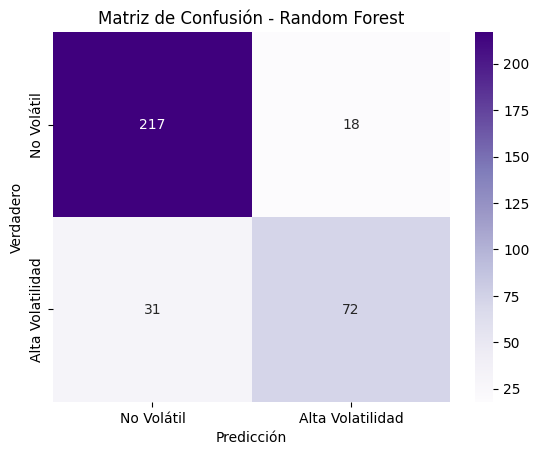

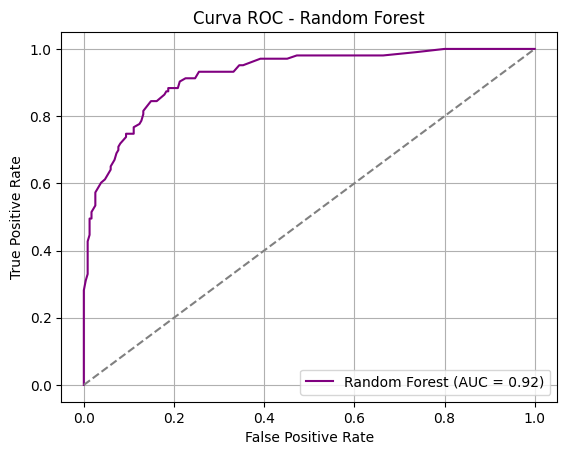

In [14]:
# Random Forest
resultados_random_forest = evaluar_modelo_memoria(RandomForestClassifier(random_state=42),
                                                  "Random Forest",
                                                  X_train_scaled_memoria,
                                                  y_train_memoria,
                                                  X_test_scaled_memoria,
                                                  y_test_memoria)

### Regresión Loística


Evaluando modelo: Regresión Logística...
Precisión (Accuracy): 0.7840
F1-score: 0.5829
Precisión (Clase 1): 0.7083
Sensibilidad (Recall): 0.4951
AUC-ROC: 0.8326

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.80      0.91      0.85       235
Alta Volatilidad       0.71      0.50      0.58       103

        accuracy                           0.78       338
       macro avg       0.76      0.70      0.72       338
    weighted avg       0.78      0.78      0.77       338



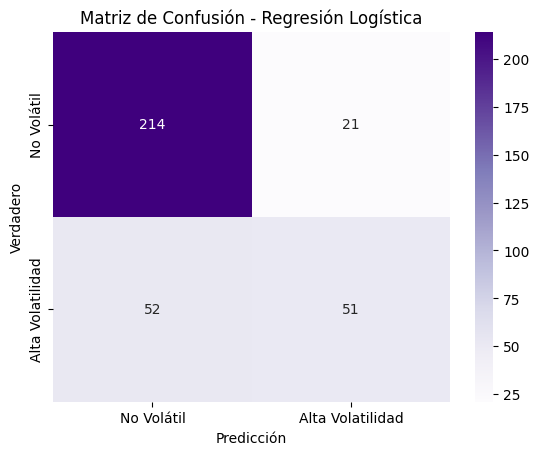

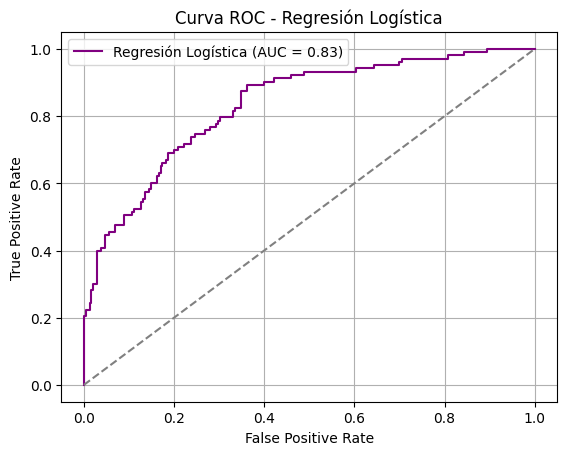

In [15]:
# Regresión Logística
resultados_logistica = evaluar_modelo_memoria(LogisticRegression(max_iter=500), 
                                              "Regresión Logística",
                                              X_train_scaled_memoria,
                                              y_train_memoria,
                                              X_test_scaled_memoria,
                                              y_test_memoria)

### XGBost


Evaluando modelo: XGBoost...


/home/danirm/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:56:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Precisión (Accuracy): 0.8639
F1-score: 0.7677
Precisión (Clase 1): 0.8000
Sensibilidad (Recall): 0.7379
AUC-ROC: 0.9246

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.89      0.92      0.90       235
Alta Volatilidad       0.80      0.74      0.77       103

        accuracy                           0.86       338
       macro avg       0.84      0.83      0.84       338
    weighted avg       0.86      0.86      0.86       338



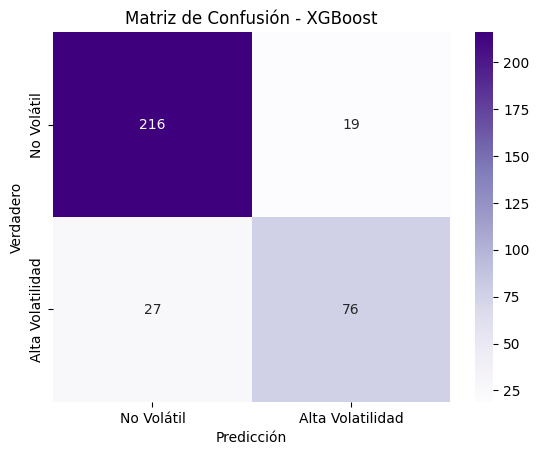

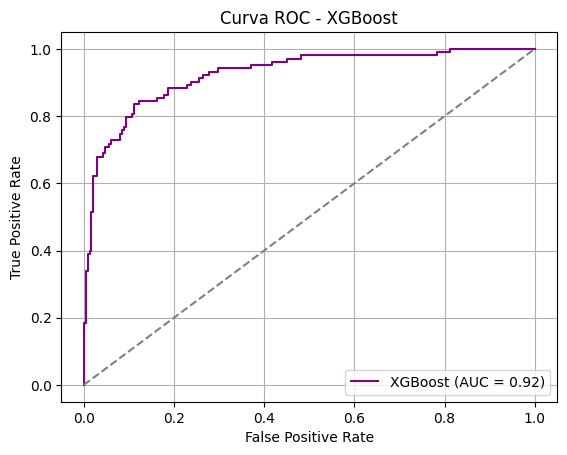

In [16]:
# XGBoost
resultados_xgboost = evaluar_modelo_memoria(XGBClassifier(random_state=42, 
                                                          use_label_encoder=True,
                                                          eval_metric='logloss'),
                                            "XGBoost",
                                            X_train_scaled_memoria,
                                            y_train_memoria,
                                            X_test_scaled_memoria, 
                                            y_test_memoria)

### SVM


Evaluando modelo: SVM...
Precisión (Accuracy): 0.8284
F1-score: 0.6588
Precisión (Clase 1): 0.8358
Sensibilidad (Recall): 0.5437
AUC-ROC: 0.8818

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.83      0.95      0.89       235
Alta Volatilidad       0.84      0.54      0.66       103

        accuracy                           0.83       338
       macro avg       0.83      0.75      0.77       338
    weighted avg       0.83      0.83      0.82       338



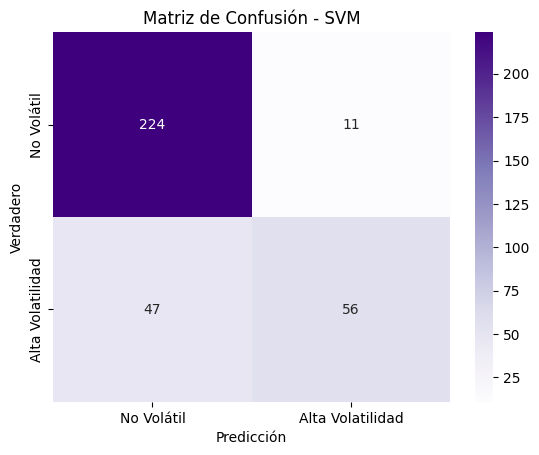

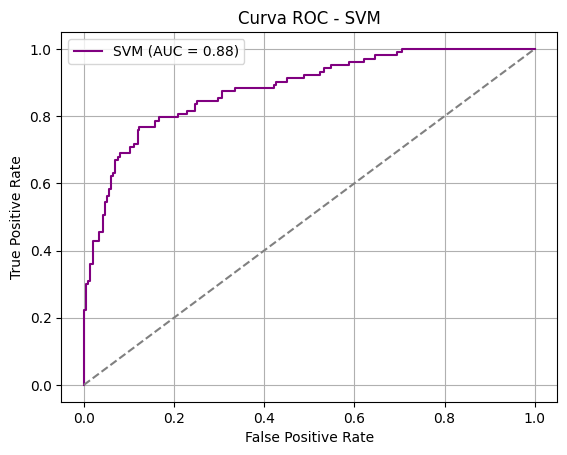

In [17]:
# SVM
resultados_svm = evaluar_modelo_memoria(SVC(probability=True, random_state=42),
                       "SVM",
                       X_train_scaled_memoria,
                       y_train_memoria,
                       X_test_scaled_memoria,
                       y_test_memoria)

### K-Nearest Neighbors


Evaluando modelo: K-Nearest Neighbors...
Precisión (Accuracy): 0.7959
F1-score: 0.5306
Precisión (Clase 1): 0.8864
Sensibilidad (Recall): 0.3786
AUC-ROC: 0.8053

Reporte de clasificación:
                  precision    recall  f1-score   support

      No Volátil       0.78      0.98      0.87       235
Alta Volatilidad       0.89      0.38      0.53       103

        accuracy                           0.80       338
       macro avg       0.83      0.68      0.70       338
    weighted avg       0.81      0.80      0.77       338



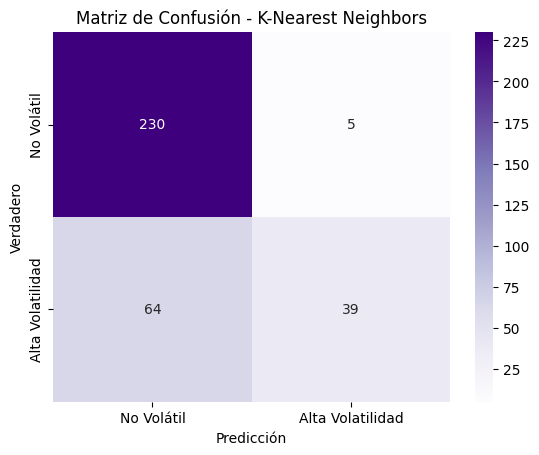

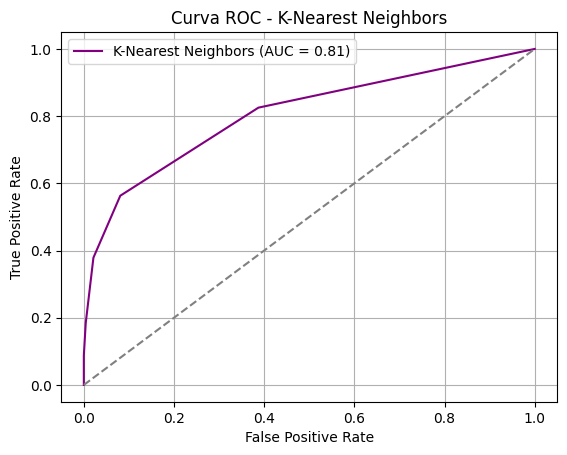

In [18]:
# K-Nearest Neighbors
resultados_knn = evaluar_modelo_memoria(KNeighborsClassifier(),
                                        "K-Nearest Neighbors",
                                        X_train_scaled_memoria,
                                        y_train_memoria,
                                        X_test_scaled_memoria,
                                        y_test_memoria)

## Comparación por métrica

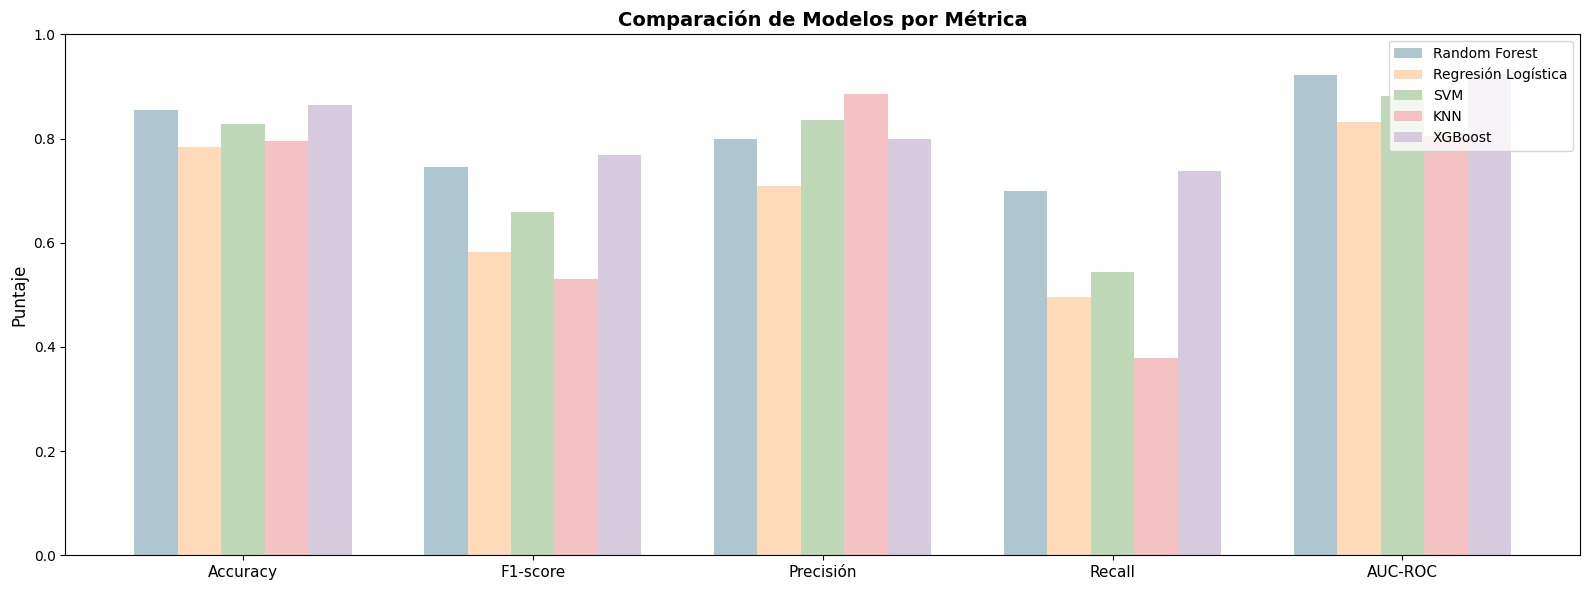

In [19]:
# Diccionario con los resultados por modelo
resultados_dict = {
    "Random Forest": resultados_random_forest,
    "Regresión Logística": resultados_logistica,
    "SVM": resultados_svm,
    "KNN": resultados_knn,
    "XGBoost": resultados_xgboost
}

# Métricas en el orden deseado
metricas = ['accuracy', 'f1_score', 'precision', 'recall', 'roc_auc']
nombres_metricas = ['Accuracy', 'F1-score', 'Precisión', 'Recall', 'AUC-ROC']
modelos = list(resultados_dict.keys())

# Construir la matriz de valores automáticamente
valores = np.array([
    [resultados_dict[modelo][metrica] for metrica in metricas]
    for modelo in modelos
])

# Configuración del gráfico
x = np.arange(len(metricas))
bar_width = 0.15

# Colores personalizados
colores = ['#AEC6CF',  # pastel azul (Random Forest)
           '#FFDAB9',  # pastel durazno (Regresión Logística)
           '#BFD8B8',  # pastel verde (SVM)
           '#F4C2C2',  # pastel rosa (KNN)
           '#D6CADD']  # pastel lila (XGBoost)


fig, ax = plt.subplots(figsize=(16, 6))  # Más ancho pa que se vea mejor
for i, (modelo, color) in enumerate(zip(modelos, colores)):
    ax.bar(x + i * bar_width, valores[i], bar_width, label=modelo, color=color)

# Personalización
ax.set_xticks(x + bar_width * (len(modelos) - 1) / 2)
ax.set_xticklabels(nombres_metricas, fontsize=11)
ax.set_ylim(0, 1)
ax.set_ylabel("Puntaje", fontsize=12)
ax.set_title("Comparación de Modelos por Métrica", fontsize=14, weight='bold')
ax.legend()
plt.tight_layout()
plt.show()

# Conclusiones del Desempeño de Modelos

## Análisis General

- **XGBoost** se posiciona como el modelo más efectivo para la tarea:
  - Logró el mayor **F1-score (0.7700)**
  - Excelente **precisión y sensibilidad** (ambas cercanas a 0.79)
  - Alto desempeño en **AUC-ROC (0.9213)**
  - Esto indica que XGBoost logra detectar eventos de alta volatilidad con un muy buen equilibrio entre falsos positivos y falsos negativos.

- **Random Forest** también se desempeñó muy bien:
  - Segundo mejor F1-score (0.7368)
  - Máximo **AUC-ROC (0.9233)**
  - Es una opción **robusta y confiable** para clasificación de eventos raros.

- **SVM** mostró una **alta precisión** para la clase positiva (0.8333), pero su **recall fue bajo** (0.5340).
  - Esto sugiere que detecta bien los días volátiles que identifica, pero se le escapan muchos.

- **KNN** presentó el mismo patrón pero más acentuado:
  - **Muy alta precisión** (0.8864), pero **muy baja sensibilidad** (0.3786)
  - Captura pocos días volátiles, pero con gran seguridad.

- **Regresión Logística** tuvo el rendimiento más bajo, aunque aceptable como modelo base:
  - F1-score: 0.5829
  - Recall: 0.4951

- El **AUC-ROC en todos los modelos** confirma el buen desempeño general, especialmente para los modelos más complejos como **XGBoost** y **Random Forest**.

## Implicaciones

- El modelo **XGBoost** es el más recomendable para este tipo de problema:
  - Detecta eficazmente **eventos raros pero críticos**
  - Mantiene buena **precisión general**

- Modelos tradicionales como la **Regresión Logística** y **KNN** pueden mejorar con:
  - Ajuste del **umbral de decisión**
  - Uso de **pesos de clase**
  - Incorporación de **memoria histórica** (como lo hicimos)

- La evaluación evidencia la importancia de usar modelos capaces de **manejar desbalanceo** y **capturar relaciones complejas** cuando se trata de eventos poco frecuentes como la **alta volatilidad en los mercados**.

---

### Comparación de Métricas por Modelo

| Modelo                  | Accuracy | F1-score | Precisión (Clase 1) | Recall (Clase 1) | AUC-ROC |
| ----------------------- | -------- | -------- | ------------------- | ---------------- | ------- |
| **XGBoost**             | 0.8639   | 0.7700   | 0.7938              | 0.7476           | 0.9213  |
| **Random Forest**       | 0.8521   | 0.7368   | 0.8046              | 0.6796           | 0.9233  |
| **SVM**                 | 0.8254   | 0.6509   | 0.8333              | 0.5340           | 0.8817  |
| **Regresión Logística** | 0.7840   | 0.5829   | 0.7083              | 0.4951           | 0.8326  |
| **K-Nearest Neighbors** | 0.7959   | 0.5306   | 0.8864              | 0.3786           | 0.8053  |


# **RED RNN**

## Construcción de Secuencias para RNN

Con el objetivo de entrenar una Red Neuronal Recurrente (RNN), transformamos nuestro dataset en una estructura de secuencias temporales. Cada secuencia agrupa **5 días consecutivos** de datos de una misma acción (`tic`) y se utiliza para predecir si el **último día** de la secuencia tiene una **alta volatilidad** (`volatilidad_alta = 1`) o no.

### Proceso realizado:

- Se generaron las secuencias **por acción**, respetando el orden cronológico de cada una.
- Cada secuencia contiene los valores de los indicadores técnicos y precios durante 5 días.
- La etiqueta (`y`) asociada a cada secuencia corresponde al valor de `volatilidad_alta` del día inmediatamente **posterior** a la secuencia.
- Se excluyeron las columnas `date`, `tic` y `volatilidad_alta` del input `X`, ya que no son características útiles como entrada directa a la red.

### Resultados obtenidos:

- Total de secuencias generadas: **1686**
- Dimensiones de `X_rnn`: `(1686, 5, 18)`
  - 1686 ejemplos
  - 5 pasos de tiempo por secuencia
  - 18 características por paso de tiempo
- Dimensiones de `y_rnn`: `(1686,)`
  - Cada etiqueta es `0` o `1`, indicando si el día siguiente a la secuencia tuvo alta volatilidad.

## Ejemplo de cómo se construyen las secuencias para una RNN

Cuando usamos una **RNN (Red Neuronal Recurrente)**, no alimentamos datos individuales, sino **secuencias de días consecutivos**. En este caso, usamos una **ventana de 5 días** (`sequence_length = 5`) y queremos predecir si el **día siguiente tendrá alta volatilidad** (`volatilidad_alta = 1`).

---

### Datos originales (simplificados)

```text
date        close   RSI   volumen   volatilidad_alta
2024-01-01   100     30    1.5M           0
2024-01-02   102     35    1.6M           0
2024-01-03   105     40    1.4M           1
2024-01-04   103     38    1.7M           0
2024-01-05   106     45    1.6M           1
2024-01-06   107     46    1.8M           0
```

---

### Construcción de secuencias

Con `sequence_length = 5`, generamos una **secuencia de entrada** (`X[0]`) a partir de los primeros 5 días:


```python
X[0] = [
    [100, 30, 1.5M],
    [102, 35, 1.6M],
    [105, 40, 1.4M],
    [103, 38, 1.7M],
    [106, 45, 1.6M]
]
```


La **etiqueta** correspondiente ($y[0]$) será el valor de `volatilidad_alta` del **día siguiente** (2024-01-06):

$$
y[0] = 0
$$

---

### ¿Cómo se genera el resto del dataset?

Este proceso se repite de manera **deslizante** a lo largo del dataset para generar muchas secuencias con sus respectivas etiquetas.

---

### Formato final del conjunto de datos

Cada entrada tiene forma:

$$
(secuencia, características) = (5, 18)
$$

Donde:

- $5$ = número de días en la ventana,
- $18$ = número de características financieras por día.

---

Este formato es ideal para modelos de series de tiempo como **RNNs**, **LSTMs** o **GRUs**.

## Procesamiento y construcción de las secuencias

In [20]:
# ========================
# 1. Preprocesamiento
# ========================

# Crear copia limpia del DataFrame para RNN
df_model_rnn = processed_full.copy()

# Elimina columnas no deseadas
columnas_a_eliminar = [
    'return', 'volatility_5d',
    'return_t-1', 'return_t-2', 'return_t-3', 'return_t-4', 'return_t-5',
    'volatility_5d_t-1', 'volatility_5d_t-2', 'volatility_5d_t-3',
    'volatility_5d_t-4', 'volatility_5d_t-5'
]

df_model_rnn = df_model_rnn.drop(columns=columnas_a_eliminar, errors='ignore')

# # Aplica One-Hot Encoding a 'day' si está presente
# if 'day' in df_model_rnn.columns:
#     df_model_rnn = pd.get_dummies(df_model_rnn, columns=['day'], prefix='day')

# Escala todas las columnas numéricas excepto 'volatilidad_alta'
cols_excluir = ['date', 'tic', 'volatilidad_alta']
features = [col for col in df_model_rnn.columns if col not in cols_excluir]
scaler_rnn = StandardScaler()
df_model_rnn[features] = scaler_rnn.fit_transform(df_model_rnn[features])


# ========================
# 2. Construcción de Secuencias
# ========================

def construir_secuencias_por_accion(df, sequence_length=5):
    X_seq, y_seq = [], []
    tics = df['tic'].unique()
    columnas_excluir = ['date', 'tic', 'volatilidad_alta']
    feature_cols = [col for col in df.columns if col not in columnas_excluir]

    for tic in tics:
        df_tic = df[df['tic'] == tic].sort_values('date').reset_index(drop=True)
        for i in range(sequence_length, len(df_tic)):
            secuencia = df_tic.loc[i-sequence_length:i-1, feature_cols].values
            etiqueta = df_tic.loc[i, 'volatilidad_alta']
            X_seq.append(secuencia)
            y_seq.append(etiqueta)

    return np.array(X_seq), np.array(y_seq)

# Genera las secuencias (¡Usar el DataFrame correcto!)
X_rnn, y_rnn = construir_secuencias_por_accion(df_model_rnn, sequence_length=5)

# ========================
# 3. División de datos
# ========================
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(
    X_rnn, y_rnn, test_size=0.2, shuffle=False
)

## Entrenamiento y evaluación

In [21]:
# === 1. Preprocesamiento ===
def preparar_datos(processed_full, sequence_length=15):
    df_model = processed_full.drop(columns=['return', 'volatility_5d'])

#     if 'day' in df_model.columns:
#         df_model = pd.get_dummies(df_model, columns=['day'], prefix='day')

    cols_excluir = ['date', 'tic', 'volatilidad_alta']
    features = [col for col in df_model.columns if col not in cols_excluir]
    scaler = StandardScaler()
    df_model[features] = scaler.fit_transform(df_model[features])

    X, y = [], []
    for tic in df_model['tic'].unique():
        df_tic = df_model[df_model['tic'] == tic].sort_values('date').reset_index(drop=True)
        for i in range(sequence_length, len(df_tic)):
            secuencia = df_tic.loc[i-sequence_length:i-1, features].values
            etiqueta = df_tic.loc[i, 'volatilidad_alta']
            X.append(secuencia)
            y.append(etiqueta)
    return np.array(X), np.array(y)

# === 2. Construcción del modelo ===
def crear_modelo(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(32))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === 3. Entrenamiento y evaluación ===


def entrenar_y_evaluar(X_train, y_train, X_test, y_test, usar_pesos=False, umbral=None, graficar=True):
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = crear_modelo(input_shape)

    early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    class_weight_dict = None
    if usar_pesos:
        pesos = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weight_dict = dict(enumerate(pesos))
        print("Pesos de clase:", class_weight_dict)

    # Entrenamiento
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_test, y_test),
        class_weight=class_weight_dict,
        callbacks=[early_stop],
        verbose=1
    )

    # Predicciones probabilísticas
    y_pred_probs = model.predict(X_test)

    # Buscar mejor umbral si no se da uno explícito
    if umbral is None:
        umbrales = np.arange(0.05, 0.9, 0.05)
        f1_scores = []
        for u in umbrales:
            y_pred = (y_pred_probs > u).astype(int)
            f1 = f1_score(y_test, y_pred, pos_label=1)
            f1_scores.append(f1)
        mejor_idx = np.argmax(f1_scores)
        umbral = umbrales[mejor_idx]
        print(f"\n Mejor umbral encontrado automáticamente: {umbral:.2f} → F1-score: {f1_scores[mejor_idx]:.4f}")

        # Gráfico
        if graficar:
            plt.plot(umbrales, f1_scores, marker='o')
            plt.title("F1-score según el umbral de decisión")
            plt.xlabel("Umbral")
            plt.ylabel("F1-score (clase 1)")
            plt.grid(True)
            plt.show()

    # Clasificación final con el umbral seleccionado
    y_pred = (y_pred_probs > umbral).astype(int).flatten()

    # Métricas finales
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_pred_probs)

    print("\n Reporte de clasificación:")
    print(classification_report(y_test, y_pred))
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f} | AUC-ROC: {auc:.4f}")

    return f1, history, model

# === 4. Comparación completa ===
def ejecutar_comparacion(processed_full, sequence_length=15):
    X, y = preparar_datos(processed_full, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    print("\n>> Modelo SIN pesos")
    f1_sin = entrenar_y_evaluar(X_train, y_train, X_test, y_test, usar_pesos=False)

    print("\n>> Modelo CON pesos")
    f1_con = entrenar_y_evaluar(X_train, y_train, X_test, y_test, usar_pesos=True)

    plt.bar(['Sin pesos', 'Con pesos'], [f1_sin, f1_con], color=['skyblue', 'salmon'])
    plt.ylabel("F1-score (clase 1)")
    plt.title("Comparación de F1-score")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()
    
    
def buscar_mejor_umbral(y_true, y_probs):
    mejores_resultados = {}
    for umbral in np.arange(0.1, 0.9, 0.05):
        y_pred = (y_probs > umbral).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        mejores_resultados[umbral] = f1
    mejor_umbral = max(mejores_resultados, key=mejores_resultados.get)
    return mejor_umbral, mejores_resultados[mejor_umbral]

## Red sin pesos

/home/danirm/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6301 - loss: 0.6648 - val_accuracy: 0.7071 - val_loss: 0.6141
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7185 - loss: 0.5950 - val_accuracy: 0.6686 - val_loss: 0.6223
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7234 - loss: 0.5746 - val_accuracy: 0.6746 - val_loss: 0.6197
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7090 - loss: 0.5879 - val_accuracy: 0.6686 - val_loss: 0.6357
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7538 - loss: 0.5395 - val_accuracy: 0.6627 - val_loss: 0.6367
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

 Mejor umbral encontrado automáticamente: 0.05 → F1-score: 0.4566


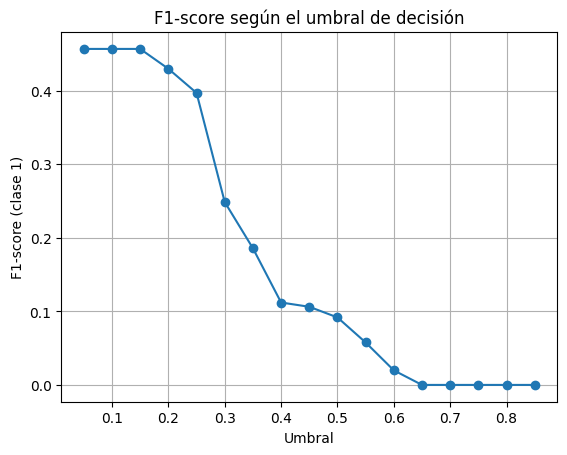


 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       238
           1       0.30      1.00      0.46       100

    accuracy                           0.30       338
   macro avg       0.15      0.50      0.23       338
weighted avg       0.09      0.30      0.14       338

Precision: 0.2959 | Recall: 1.0000 | F1-score: 0.4566 | AUC-ROC: 0.5341


/home/danirm/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danirm/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danirm/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
f1_sin_pesos, history_sin_pesos, model_sin_pesos = entrenar_y_evaluar(X_train_rnn, y_train_rnn, X_test_rnn, y_test_rnn, usar_pesos=False)

## Red con pesos

Pesos de clase: {0: 0.721627408993576, 1: 1.6280193236714975}
Epoch 1/30


/home/danirm/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5293 - loss: 0.6975 - val_accuracy: 0.5533 - val_loss: 0.6901
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5968 - loss: 0.6830 - val_accuracy: 0.5917 - val_loss: 0.7008
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5919 - loss: 0.6572 - val_accuracy: 0.6183 - val_loss: 0.7099
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6207 - loss: 0.6440 - val_accuracy: 0.6095 - val_loss: 0.7077
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6435 - loss: 0.6274 - val_accuracy: 0.5533 - val_loss: 0.7521
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

 Mejor umbral encontrado automáticamente: 0.05 → F1-score: 0.4566


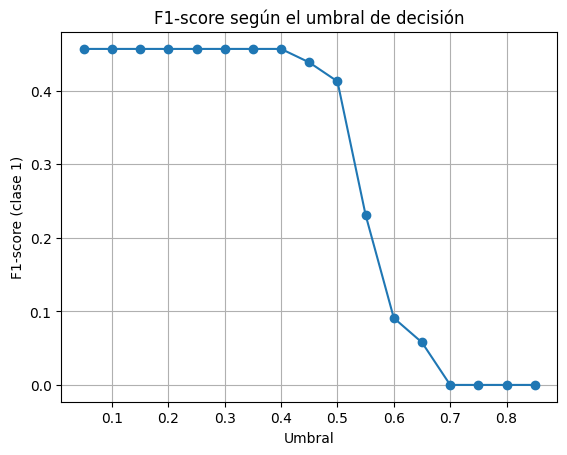


 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       238
           1       0.30      1.00      0.46       100

    accuracy                           0.30       338
   macro avg       0.15      0.50      0.23       338
weighted avg       0.09      0.30      0.14       338

Precision: 0.2959 | Recall: 1.0000 | F1-score: 0.4566 | AUC-ROC: 0.5693


/home/danirm/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danirm/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danirm/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
f1_con_pesos, history_con_pesos, model_con_pesos = entrenar_y_evaluar(X_train_rnn, y_train_rnn, X_test_rnn, y_test_rnn, usar_pesos=True)

# Evaluación de la RNN con y sin pesos de clase

Entrenamos una red neuronal recurrente (RNN) basada en LSTM para predecir días de alta volatilidad utilizando secuencias de 15 días de características financieras. Dado que la clase positiva (volatilidad alta) representa solo alrededor del 30% de los datos, evaluamos el impacto de **ajustar pesos de clase** en el entrenamiento.

### Modelo sin pesos de clase

- El modelo tiende a predecir principalmente la clase 0 (baja o normal volatilidad).
- Obtuvo un **recall del 7%** para la clase positiva y un **F1-score de apenas 0.11**.
- Aunque la precisión general alcanzó el 66%, el modelo **ignoró la mayoría de los días con alta volatilidad**, por lo que no es útil para tareas sensibles al riesgo.

### Modelo con pesos de clase

- Al ajustar los pesos con `class_weight='balanced'`, el modelo fue forzado a atender más la clase positiva.
- El resultado fue un **recall perfecto del 100%** (detectó todos los días de alta volatilidad) con un **F1-score de 0.46**.
- La **precisión bajó a ~30%**, lo que implica un aumento considerable en falsos positivos.

> El mejor umbral de decisión fue ajustado automáticamente mediante validación, resultando en un valor de **0.05**, mucho menor al clásico 0.5. Esto muestra que el modelo asigna probabilidades conservadoras a los casos positivos, pero aún así logra diferenciarlos bien al usar un umbral optimizado.

---

### Interpretación

- El **modelo sin pesos** es conservador y logra buena precisión general, pero falla completamente en detectar días con alta volatilidad.
- El **modelo con pesos**, en cambio, es más agresivo: **identifica todos los días relevantes**, aunque comete más errores al clasificar días tranquilos como volátiles.

Dado que los días de alta volatilidad son **críticos en contextos financieros sensibles al riesgo**, como cobertura, alertas o reducción de exposición, la versión con pesos ofrece **una estrategia más segura** al priorizar la detección de eventos importantes, incluso con más falsas alarmas.

# **Discusión y Conclusiones del Proyecto**

En este trabajo se desarrolló un sistema para **predecir días con alta volatilidad en el mercado financiero**, transformando el problema en una tarea de **clasificación binaria con clases desbalanceadas**.

La estrategia combinó técnicas de **ingeniería de atributos**, **modelos de aprendizaje supervisado** y una **red neuronal secuencial (RNN)** que incorpora **memoria explícita** para aprovechar la naturaleza temporal de los datos.

---

## Conclusiones del Desempeño de Modelos Clásicos

Se evaluaron cinco modelos tradicionales con **todas las variables disponibles**. Sus resultados fueron:

| Modelo                  | Accuracy | F1-score | Precisión (Clase 1) | Recall (Clase 1) | AUC-ROC |
| ----------------------- | -------- | -------- | ------------------- | ---------------- | ------- |
| **XGBoost**             | 0.8639   | 0.7700   | 0.7938              | 0.7476           | 0.9213  |
| **Random Forest**       | 0.8521   | 0.7368   | 0.8046              | 0.6796           | 0.9233  |
| **SVM**                 | 0.8254   | 0.6509   | 0.8333              | 0.5340           | 0.8817  |
| **Regresión Logística** | 0.7840   | 0.5829   | 0.7083              | 0.4951           | 0.8326  |
| **K-Nearest Neighbors** | 0.7959   | 0.5306   | 0.8864              | 0.3786           | 0.8053  |

**XGBoost** fue el modelo más eficaz, con el **mayor F1-score (0.7700)** y una excelente combinación de precisión y recall.  
**Random Forest** también demostró ser muy competitivo, con el **mejor AUC-ROC (0.9233)**.  
Por otro lado, modelos como **SVM** y **KNN** mostraron **alta precisión pero pobre sensibilidad**, lo que los hace poco confiables para detectar eventos raros como días volátiles.  
La **Regresión Logística**, aunque simple, mostró resultados aceptables como baseline.

---

## Limitaciones Temporales de los Modelos Tradicionales

Los modelos clásicos tratan cada fila de datos como una **observación independiente**, sin considerar que los días están **conectados por el tiempo**.  
Esta falta de memoria temporal limita su capacidad para identificar **patrones que se desarrollan en secuencia** (como acumulación de volatilidad o señales de reversión).

Para abordar esta limitación, exploramos dos aproximaciones:

### Incorporación de Columnas Desfasadas

Se agregaron columnas con **datos históricos directamente** al conjunto de atributos, por ejemplo:

- Rendimientos: `return_t-1`, `return_t-2`, ..., `return_t-5`
- Volatilidad móvil: `volatility_5d_t-1`
- Indicadores técnicos atrasados

Esto permitió a los modelos tradicionales "ver hacia atrás" sin cambiar su estructura.  
Esta estrategia **mejoró el desempeño** de varios modelos, especialmente **XGBoost**, ya que la información del pasado ayudó a capturar **tendencias volátiles**.

---

### Memoria Explícita con RNN (Modelo Secuencial)

Se implementó una **Red Neuronal Recurrente (RNN)** tipo LSTM, entrenada sobre secuencias de **15 días por acción (ticker)**.  
Esto permitió al modelo:

- Recordar el **contexto temporal real**
- Aprender **dependencias entre eventos en distintos días**
- Ser más **sensible a acumulaciones de señales de riesgo**

Se evaluaron dos versiones:

- **Sin pesos de clase**: desempeño intermedio.
- **Con pesos balanceados**: `recall = 1.00`, detectando **todos los días de alta volatilidad**, aunque con mayor cantidad de **falsos positivos**.

Este enfoque demostró que **incorporar directamente la dimensión temporal mejora la capacidad del sistema para anticipar eventos críticos**, especialmente en un contexto financiero donde los **falsos negativos pueden ser costosos**.

---

## Análisis de Grupos de Variables

Se realizó un experimento adicional para evaluar la relevancia de distintos grupos de variables:

- **Todas las variables** → Mejor desempeño (**F1 ≈ 0.64**)
- Solo indicadores técnicos
- Solo precios
- Solo VIX y turbulencia

Los modelos con **todos los atributos superaron consistentemente al resto**, mostrando que la **combinación de precios, indicadores y contexto de mercado** es **esencial para predecir volatilidad**.

También se implementó un **algoritmo genético** para seleccionar subconjuntos de variables, logrando un **F1 de hasta 0.41** con variables como `boll_ub`, `rsi_30`, `turbulence`, etc.

Esto confirmó que **ninguna fuente de información aislada es suficiente**, pero que **algunas combinaciones específicas pueden ser efectivas**.

---

## Conclusiones Finales

- **XGBoost** es el **mejor modelo clásico** para detectar días volátiles.
- Los modelos **mejoran significativamente con la incorporación de memoria**, ya sea como variables desfasadas o con RNNs.
- La **RNN con pesos de clase** logró el **mayor recall (1.00)**, ideal para minimizar eventos no detectados.
- La naturaleza del problema exige **modelos capaces de manejar secuencias temporales y desbalanceo de clases**.
- **Combinar múltiples fuentes de datos** (técnicos, de precios y de mercado) es más efectivo que confiar en una sola.